In [72]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt

In [2]:
EXTRACTED_FEATURES_DB_NAME = '/data/experiments/YHE/extracted-features/extracted-features.sqlite'

In [3]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query("select * from features", db_conn)
db_conn.close()

In [4]:
sequences_df[['sequence','charge','run_name','number_of_runs_extracted','human','group','classed_as']].sample(n=5)

,sequence,charge,run_name,number_of_runs_extracted,human,group,classed_as
226280,WCEYGLTFTEK,2,YHE114_07_Slot1-1_1_3014,31,1,YHE114,decoy
212430,LEESGWQVNNNMNHNMNK,2,YHE114_07_Slot1-1_1_3014,30,1,YHE114,target
503960,DLESIDPEFYNSLIWVK,2,YHE114_11_Slot1-1_1_3043,25,1,YHE114,target
174872,ELLNALFSNPMDDNLICAVK,2,YHE211_09_Slot1-1_1_3005,31,1,YHE211,target
669690,ATFCLPILGVK,2,YHE211_07_Slot1-1_1_3003,31,1,YHE211,decoy


In [5]:
sequences_df['group'] = sequences_df.run_name.apply(lambda x: x.split('_')[0])

In [6]:
sequences_df[['sequence','charge','run_name','number_of_runs_extracted','human','group']].sample(n=5)

,sequence,charge,run_name,number_of_runs_extracted,human,group
848366,EYDELNVAPYNPVVCSGPHCK,2,YHE211_04_Slot1-1_1_3000,29,0,YHE211
697749,AGEGRPNGEGAEPGPGR,2,YHE010_10_Slot1-1_1_2995,31,1,YHE010
854259,KEKEPEEELYDLSK,2,YHE211_04_Slot1-1_1_3000,31,1,YHE211
655544,MGYAEEAPYDAIHVGAAAPVVPQALIDQLKPGGR,3,YHE211_08_Slot1-1_1_3004,27,1,YHE211
231977,DPTGMDPDDIWQLSSSLK,2,YHE211_03_Slot1-1_1_2999,31,1,YHE211


In [7]:
yhe_only_df = sequences_df[(sequences_df.group == 'YHE211') | (sequences_df.group == 'YHE114')]
yhe_only_targets_df = yhe_only_df[(yhe_only_df.classed_as == 'target')]

In [8]:
number_of_yhe_runs_in_experiment = len(yhe_only_df.file_idx.unique())
print('there are {} runs in the experiment'.format(number_of_yhe_runs_in_experiment))

there are 21 runs in the experiment


#### analyse the rate of successful extractions of peptides in the library

In [9]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in yhe_only_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df.file_idx.unique())))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [10]:
# display the number of missing extractions across the experiment
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_extracted
proportion_of_missing_extractions = yhe_sequence_occurences_df.missing_files.sum() / (len(yhe_sequence_occurences_df) * number_of_yhe_runs_in_experiment)
print("{}% of extractions missing across the experiment.".format(round(proportion_of_missing_extractions*100)))

7.0% of extractions missing across the experiment.


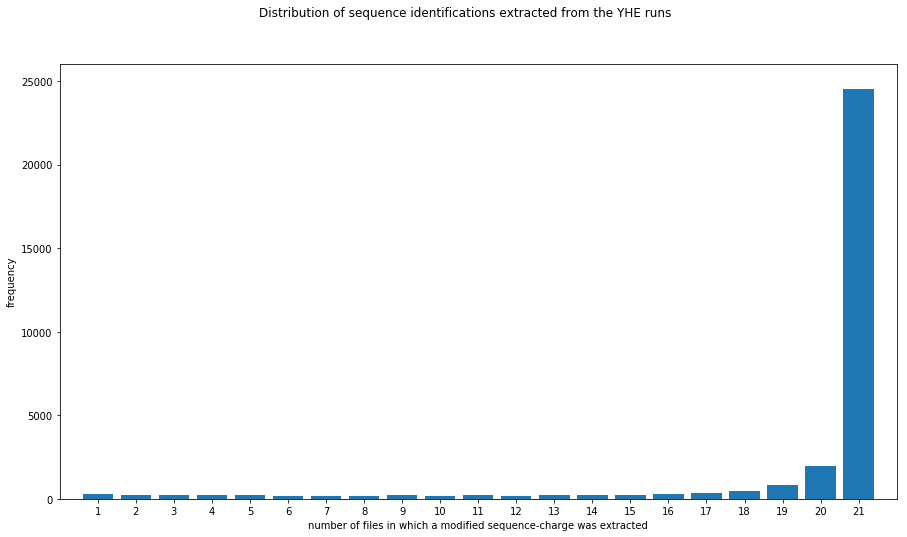

In [11]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications extracted from the YHE runs')
# plt.title('total {} modified peptide sequences'.format(modified_sequences_count))

counts = np.bincount(yhe_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(22), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was extracted')
plt.ylabel('frequency')
ax1.set(xticks=range(1,22), xlim=[0, 22])
# plt.ylim((0,20000))

plt.show()

In [12]:
yhe_only_targets_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_coords',
       'theoretical_mz', 'q_value', 'delta_mz_ppm', 'delta_rt', 'delta_scan',
       'fwhm_rt_0', 'fwhm_scan_0', 'geometric_mean_0_1',
       'geometric_mean_0_1_2', 'isotope_0_1_mz_delta_ppm',
       'isotope_0_1_rt_delta', 'isotope_0_1_scan_delta',
       'isotope_0_2_mz_delta_ppm', 'isotope_0_2_rt_delta',
       'isotope_0_2_scan_delta', 'monoisotope_auc_over_isotope_peak_auc_sum',
       'monoisotope_int_over_isotope_peak_int_sum', 'mz_delta_ppm_std_dev_0',
       'mz_delta_ppm_std_dev_1', 'number_of_frames_0', 'number_of_frames_1',
       'number_of_frames_2', 'number_of_missing_frames_0',
       'number_of_missing_frames_1', 'number_of_missing_frames_2',
       'peak_base_width_rt_0', 'peak_base_width_scan_0', 'r_squared_phr',
       'rt_isotope_correlation', 'rt_isotope_cv', 'rt_peak_symmetry_0',
       'rt_peak_symmetry_1', 'rt_peak_symmetry_2', 'scan_isotope_correlation',
       'scan_isotope_cv', 'scan_peak

In [13]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in yhe_only_targets_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.file_idx.unique()), group_name[0], group_name[1]))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_targets_extracted','sequence','charge'])

In [14]:
# display the number of missing values across the experiment
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_targets_extracted
proportion_of_missing_values = yhe_sequence_occurences_df.missing_files.sum() / (len(yhe_sequence_occurences_df) * number_of_yhe_runs_in_experiment)
print("{}% of values are missing across the YHE-only runs.".format(round(proportion_of_missing_values*100)))

18.0% of values are missing across the YHE-only runs.


In [15]:
yhe_sequence_occurences_df.sample(n=10)[['sequence','charge','number_of_runs_targets_extracted','missing_files']]

,sequence,charge,number_of_runs_targets_extracted,missing_files
25904,TSPSPTGPNPNNSPSPSSPISR,2,4,17
29223,YFNPTGAHASGCIGEDPQGIPNNLMPYVSQVAIGR,3,21,0
14643,LESEEEGVPSTAIR,2,21,0
10238,GSGVYSLLNQEDSSTSSADPK,3,13,8
28309,VTSVGTGNFSSSVSK,2,9,12
3555,DGQVINETSQHHDDLE,2,20,1
1748,AQDPSEVLTMLTNETGFEISSSDATVK,2,21,0
19651,NVGSQTLQTFKAR,2,21,0
17183,LYFLQCETCHSR,3,18,3
14904,LGELPSWILMR,2,21,0


In [16]:
df = yhe_only_df[(yhe_only_df.sequence == 'EHHIDPTAITR') & (yhe_only_df.charge == 2)][['sequence','charge','file_idx','classed_as','prob_target']]
df

,sequence,charge,file_idx,classed_as,prob_target
5852,EHHIDPTAITR,2,16,target,0.998782
35214,EHHIDPTAITR,2,28,target,0.998985
90264,EHHIDPTAITR,2,23,target,0.749908
144927,EHHIDPTAITR,2,15,target,0.999727
174500,EHHIDPTAITR,2,9,target,0.998874
204060,EHHIDPTAITR,2,25,target,0.946110
233557,EHHIDPTAITR,2,24,target,0.996008
289452,EHHIDPTAITR,2,27,target,0.999569
343170,EHHIDPTAITR,2,20,target,0.871875
371629,EHHIDPTAITR,2,29,target,0.932164


In [17]:
len(yhe_only_df[yhe_only_df.classed_as == 'decoy']) / len(yhe_only_df[yhe_only_df.classed_as == 'target'])

0.19080700123915736

In [18]:
unique_sequences_yhe_df = yhe_only_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
len(unique_sequences_yhe_df)

31659

In [19]:
unique_sequences_all_runs_df = sequences_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
len(unique_sequences_all_runs_df)

31905

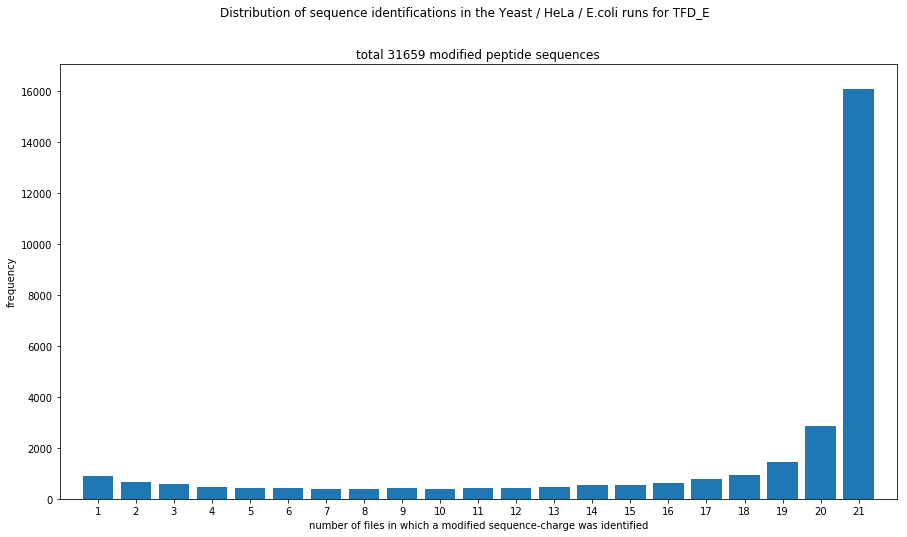

In [20]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the Yeast / HeLa / E.coli runs for TFD_E')
plt.title('total {} modified peptide sequences'.format(len(unique_sequences_yhe_df)))

counts = np.bincount(yhe_sequence_occurences_df.number_of_runs_targets_extracted)
ax1.bar(range(22), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,22), xlim=[0, 22])
# plt.ylim((0,20000))

plt.show()

#### now analyse the human-only runs

In [75]:
human_only_df = sequences_df[(sequences_df.group == 'YHE010')].copy()
human_only_targets_df = human_only_df[(human_only_df.classed_as == 'target')]

In [76]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in human_only_targets_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.file_idx.unique()), group_name[0], group_name[1], group_df.iloc[0].human))
human_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_targets_extracted','sequence','charge','human'])


In [77]:
# proportion of false positives i.e. non-human peptides found in the human-only runs
print('false positives: {}%'.format(round(len(human_sequence_occurences_df[(human_sequence_occurences_df.human == 0)]) / len(human_sequence_occurences_df) * 100.0, 1)))

false positives: 11.7%


In [78]:
number_of_human_runs_in_experiment = len(human_only_df.file_idx.unique())
print('there are {} human-only runs in the experiment'.format(number_of_human_runs_in_experiment))

there are 10 human-only runs in the experiment


In [79]:
# display the number of missing values across the experiment
human_sequence_occurences_df['missing_files'] = number_of_human_runs_in_experiment - human_sequence_occurences_df.number_of_runs_targets_extracted
proportion_of_missing_values = human_sequence_occurences_df.missing_files.sum() / (len(human_sequence_occurences_df) * number_of_human_runs_in_experiment)
print("{}% of values are missing in the human-only runs.".format(round(proportion_of_missing_values*100)))

23.0% of values are missing in the human-only runs.


In [80]:
human_sequence_occurences_df.sample(n=10)[['sequence','charge','number_of_runs_targets_extracted','missing_files']]

,sequence,charge,number_of_runs_targets_extracted,missing_files
19172,SEVFSTYADNQPGVLIQVFEGER,3,2,8
7666,GEDTGTCQGLPDSESSFTYTLDEK,2,10,0
15371,MYDLNSNNPNPIISYDGVNK,2,10,0
22346,VAELVEFLLLK,2,10,0
14837,MGELASESQGSK,2,9,1
19497,SINPDEAVAYGAAVQAAILM[15.9949]GDK,2,10,0
10558,IISNASCTTNCLAPLAK,2,10,0
11482,IYYSEETSSDQGNEDEEEPK,2,1,9
17824,Q[-17.0265]EKPAEKPAETPVATSPTATDSTSGDSSR,2,3,7
22674,VEGEFPTEEVTCK,2,10,0


In [81]:
df = human_only_df[(human_only_df.sequence == 'APVAIGVAAMSTAEMLTSGLK') & (human_only_df.charge == 2)][['sequence','charge','file_idx','classed_as','prob_target']]
df

,sequence,charge,file_idx,classed_as,prob_target
60106,APVAIGVAAMSTAEMLTSGLK,2,4,target,0.999214
115175,APVAIGVAAMSTAEMLTSGLK,2,17,target,0.999445
258615,APVAIGVAAMSTAEMLTSGLK,2,1,target,0.957707
314473,APVAIGVAAMSTAEMLTSGLK,2,6,target,0.989224
394816,APVAIGVAAMSTAEMLTSGLK,2,12,target,0.980972
421445,APVAIGVAAMSTAEMLTSGLK,2,3,target,0.951320
447007,APVAIGVAAMSTAEMLTSGLK,2,2,decoy,0.476260
560275,APVAIGVAAMSTAEMLTSGLK,2,5,target,0.981317
613658,APVAIGVAAMSTAEMLTSGLK,2,19,target,0.999955
698555,APVAIGVAAMSTAEMLTSGLK,2,7,target,0.991500


In [82]:
len(df)

10

In [83]:
unique_sequences_human_only_df = human_only_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
len(unique_sequences_human_only_df)

28814

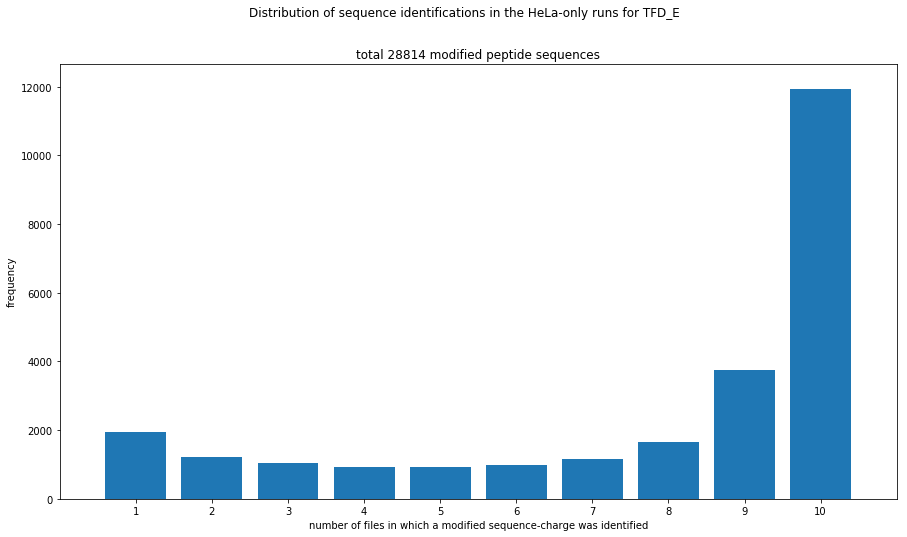

In [84]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the HeLa-only runs for TFD_E')
plt.title('total {} modified peptide sequences'.format(len(unique_sequences_human_only_df)))

counts = np.bincount(human_sequence_occurences_df.number_of_runs_targets_extracted)
ax1.bar(range(11), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,11), xlim=[0, 11])
# plt.ylim((0,20000))

plt.show()

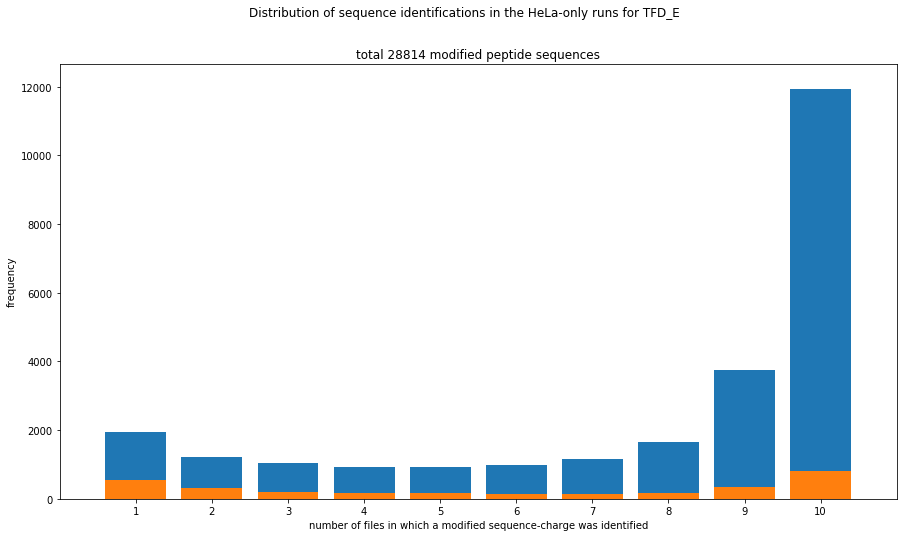

In [85]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the HeLa-only runs for TFD_E')
plt.title('total {} modified peptide sequences'.format(len(unique_sequences_human_only_df)))

counts_human = np.bincount(human_sequence_occurences_df[human_sequence_occurences_df.human == True].number_of_runs_targets_extracted)
counts_other = np.bincount(human_sequence_occurences_df[human_sequence_occurences_df.human == False].number_of_runs_targets_extracted)

ax1.bar(range(11), counts_human, bottom=counts_other, width=0.8, align='center')
ax1.bar(range(11), counts_other, width=0.8, align='center')

plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,11), xlim=[0, 11])
# plt.ylim((0,20000))

plt.show()

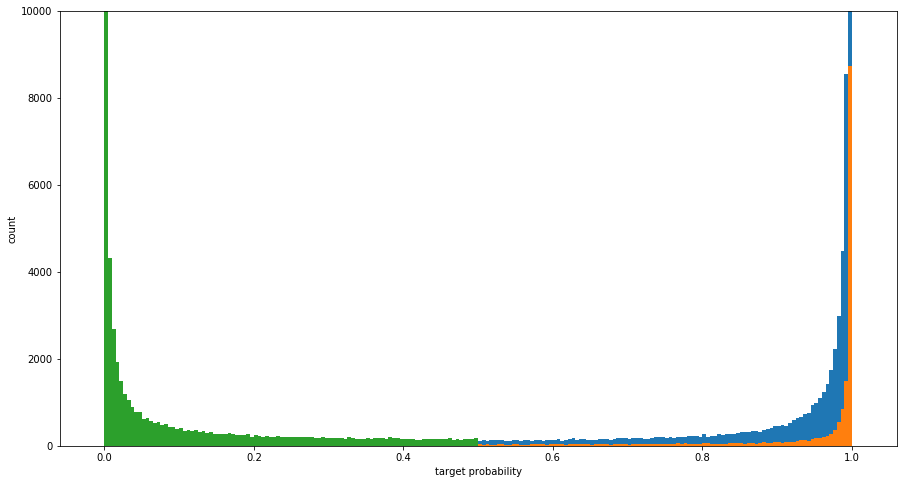

In [86]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
values_targets_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].prob_target
values_targets_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].prob_target
values_decoys = human_only_df[human_only_df.classed_as == 'decoy'].prob_target

y, x, _ = ax1.hist(values_targets_human, bins=bins)
y, x, _ = ax1.hist(values_targets_other, bins=bins)
y, x, _ = ax1.hist(values_decoys, bins=bins)
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('target probability')
plt.ylabel('count')
# plt.title('pre-normalisation sequence intensity coefficient of variance across 1to1 runs, k={}\n({} unique sequences appearing in all runs)'.format(number_of_neighbours, len(sequence_cv_df)))
# plt.xlim((0,120))
plt.ylim((0,10000))

plt.show()

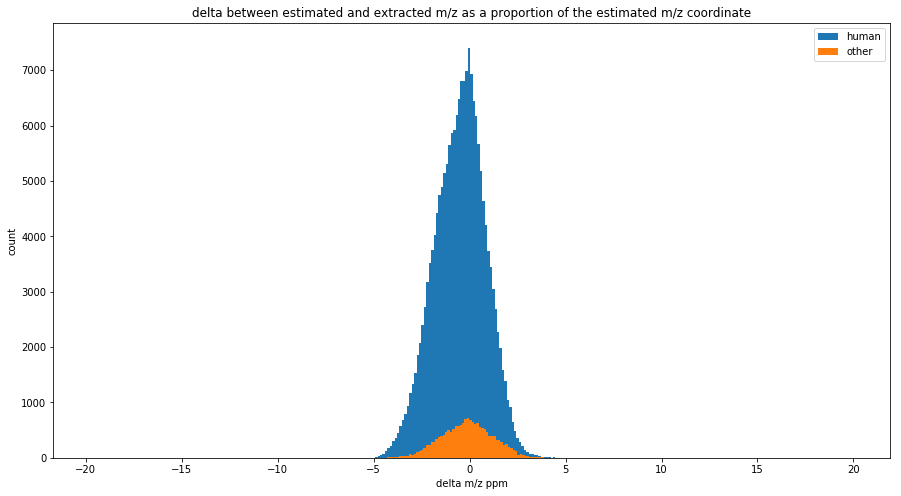

In [87]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
mz_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].delta_mz_ppm
mz_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].delta_mz_ppm

y, x, _ = ax1.hist(mz_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(mz_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta m/z ppm')
plt.ylabel('count')
plt.title('delta between estimated and extracted m/z as a proportion of the estimated m/z coordinate')
plt.legend(loc='best')
# plt.xlim((0,120))
# plt.ylim((0,10000))

plt.show()

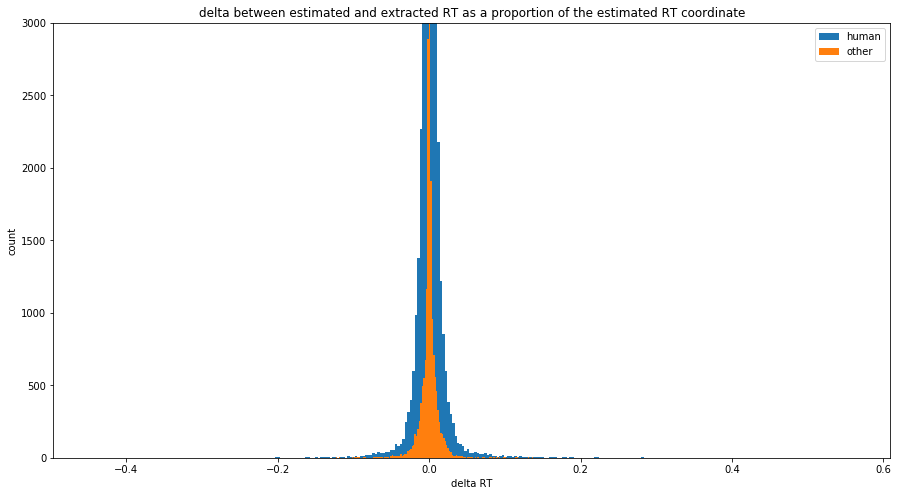

In [88]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
rt_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].delta_rt
rt_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].delta_rt

y, x, _ = ax1.hist(rt_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(rt_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta RT')
plt.ylabel('count')
plt.title('delta between estimated and extracted RT as a proportion of the estimated RT coordinate')
plt.legend(loc='best')
# plt.xlim((0,120))
plt.ylim((0,3000))

plt.show()

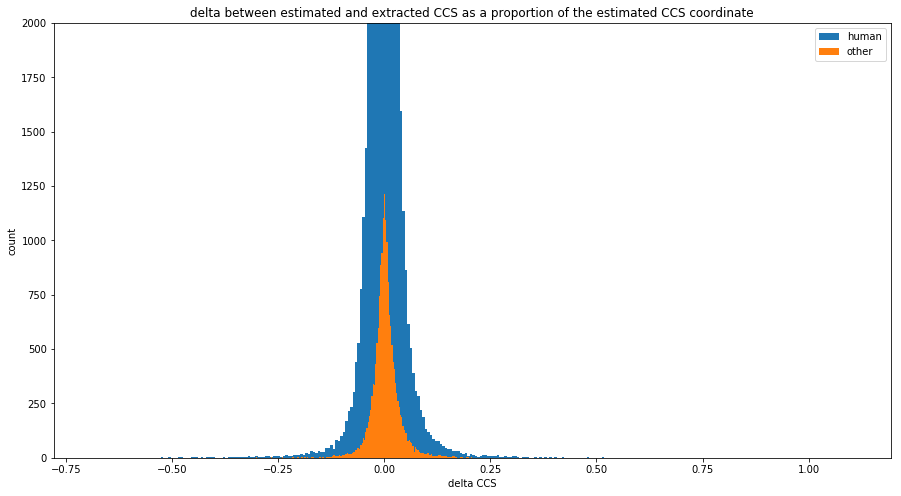

In [89]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
scan_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].delta_scan
scan_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].delta_scan

y, x, _ = ax1.hist(scan_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(scan_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta CCS')
plt.ylabel('count')
plt.title('delta between estimated and extracted CCS as a proportion of the estimated CCS coordinate')
plt.legend(loc='best')
# plt.xlim((0,120))
plt.ylim((0,2000))

plt.show()

In [90]:
df = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False) & (abs(human_only_df.delta_scan <= 0.1)) & (abs(human_only_df.delta_rt <= 0.05)) & (abs(human_only_df.delta_mz_ppm <= 1))]

len(df)

13689

In [91]:
len(df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False))

2796

In [92]:
human_only_df['sequence_charge'] = human_only_df.apply(lambda row: '{}-{}'.format(row.sequence, row.charge), axis=1)

In [95]:
human_only_df.target_coords = human_only_df.apply(lambda row: json.loads(row.target_coords), axis=1)

In [98]:
human_only_df['estimated_rt_apex'] = human_only_df.apply(lambda row: row.target_coords['rt_apex'], axis=1)
human_only_df['estimated_scan_apex'] = human_only_df.apply(lambda row: row.target_coords['scan_apex'], axis=1)
human_only_df['estimated_monoisotopic_mz'] = human_only_df.apply(lambda row: row.target_coords['mono_mz'], axis=1)

In [99]:
human_only_df['absolute_delta_rt'] = human_only_df.delta_rt * human_only_df.estimated_rt_apex
human_only_df['absolute_delta_scan'] = human_only_df.delta_scan * human_only_df.estimated_scan_apex

In [100]:
non_human_df = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)]
human_df = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)]

In [40]:
len(non_human_df)

17532

In [41]:
len(human_df)

178935

In [42]:
non_human_df.sample(n=5)

,sequence,charge,file_idx,peak_idx,target_coords,theoretical_mz,q_value,delta_mz_ppm,delta_rt,delta_scan,...,number_of_isotopes,peak_proportion_intensity,peak_proportions,rt_apex,scan_apex,run_name,group,human,number_of_runs_extracted,sequence_charge
64118,ELPGVAFLSEK,2,4,0,"{""mono_mz"": 595.3253646334565, ""scan_apex"": 71...",595.326776,0.000073,-0.248005,0.000345,-0.030720,...,7,1000,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1913.661837,694,YHE010_09_Slot1-1_1_2994,YHE010,0,31,ELPGVAFLSEK-2
263184,EQVM[15.9949]VAVQSLNPDHDSRVEAIDK,2,1,0,"{""mono_mz"": 1298.6390390016372, ""scan_apex"": 2...",1298.637176,0.000581,-0.024861,0.000357,0.005140,...,6,613,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1780.849098,300,YHE010_05_Slot1-1_1_2990,YHE010,0,12,EQVM[15.9949]VAVQSLNPDHDSRVEAIDK-2
713451,NNLPVYVNQVHEVCK,2,7,0,"{""mono_mz"": 906.956974830647, ""scan_apex"": 483...",906.956708,0.000034,0.041313,0.001380,-0.025652,...,7,2639,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1638.205926,471,YHE010_10_Slot1-1_1_2995,YHE010,0,31,NNLPVYVNQVHEVCK-2
620634,GILNQIDNLPFLTK,2,19,0,"{""mono_mz"": 793.450763975388, ""scan_apex"": 567...",793.451026,0.000004,-0.560563,0.001555,0.017253,...,7,2796,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",2132.084451,577,YHE010_04_Slot1-1_1_2989,YHE010,0,31,GILNQIDNLPFLTK-2
315953,DGPLSTNVEAK,2,6,1,"{""mono_mz"": 565.7880048432718, ""scan_apex"": 73...",565.788026,0.000004,0.082530,0.043665,0.009195,...,7,12085,"{""ccs_proportion"": 0.1, ""rt_proportion"": 0.8}",1643.958173,741,YHE010_11_Slot1-1_1_3041,YHE010,0,31,DGPLSTNVEAK-2


In [43]:
human_df.columns

Index(['sequence', 'charge', 'file_idx', 'peak_idx', 'target_coords',
       'theoretical_mz', 'q_value', 'delta_mz_ppm', 'delta_rt', 'delta_scan',
       'fwhm_rt_0', 'fwhm_scan_0', 'geometric_mean_0_1',
       'geometric_mean_0_1_2', 'isotope_0_1_mz_delta_ppm',
       'isotope_0_1_rt_delta', 'isotope_0_1_scan_delta',
       'isotope_0_2_mz_delta_ppm', 'isotope_0_2_rt_delta',
       'isotope_0_2_scan_delta', 'monoisotope_auc_over_isotope_peak_auc_sum',
       'monoisotope_int_over_isotope_peak_int_sum', 'mz_delta_ppm_std_dev_0',
       'mz_delta_ppm_std_dev_1', 'number_of_frames_0', 'number_of_frames_1',
       'number_of_frames_2', 'number_of_missing_frames_0',
       'number_of_missing_frames_1', 'number_of_missing_frames_2',
       'peak_base_width_rt_0', 'peak_base_width_scan_0', 'r_squared_phr',
       'rt_isotope_correlation', 'rt_isotope_cv', 'rt_peak_symmetry_0',
       'rt_peak_symmetry_1', 'rt_peak_symmetry_2', 'scan_isotope_correlation',
       'scan_isotope_cv', 'scan_peak

In [44]:
MZ_TOLERANCE_PPM = 5  # +/- this amount
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

RT_DELTA = 0.05
CCS_DELTA = 0.1

In [45]:
# count how many human sequences are in the same place in the same file as each non-human sequence
number_of_human_neighbours_l = []
for row in non_human_df.itertuples():
    MZ_DELTA = row.monoisotopic_mz_centroid * MZ_TOLERANCE_PERCENT / 100

    human_neighbours_df = human_df[(human_df.file_idx == row.file_idx) &
                                   (abs(human_df.monoisotopic_mz_centroid - row.monoisotopic_mz_centroid) <= MZ_DELTA) &
                                   (abs(human_df.rt_apex - row.rt_apex) <= RT_DELTA) &
                                   (abs(human_df.scan_apex - row.scan_apex) <= CCS_DELTA)
                                  ]
    neighbours_l = human_neighbours_df.sequence_charge.to_list()
    number_of_human_neighbours_l.append((row.sequence, row.charge, row.file_idx, len(human_neighbours_df), neighbours_l))


In [46]:
number_of_human_neighbours_df = pd.DataFrame(number_of_human_neighbours_l, columns=['sequence','charge','file_idx','number_of_human_neighbours','human_neighbours'])

In [47]:
number_of_human_neighbours_df[number_of_human_neighbours_df.number_of_human_neighbours >= 1]

,sequence,charge,file_idx,number_of_human_neighbours,human_neighbours
52,AIMGLPLTPYPVEK,2,4,1,[LLTGELLPTDGMIR-2]
54,ALAEFLFDDESNVIR,2,4,1,[EFNEEGALSVLQQFK-2]
59,ALGLIENVYLFGTPAVM[15.9949]K,2,4,1,[TYLTITDTQLVNSLLEK-2]
91,AQTDEVLENPDPR,2,4,1,[FSTVAGESGSADTVR-2]
100,ASTSINVPDPTPFVTYF,2,4,1,[MYVFGGWVPLVMDDVK-2]
...,...,...,...,...,...
17121,SSPDENSTLLSNDSISLK,2,7,1,[VDEFVTHNLSFDEINK-2]
17312,VEVETPEENTGDVIGDLSR,2,7,1,[LDEMEFNPVQQPQLNEK-2]
17469,YFLLTDYSLWSGILYNPDLPK,3,7,1,[SPNPSLLHLCGSLAQLACVEPVR-3]
17482,YIDAARVAFGSK,2,7,1,[LYDMVLQFLR-2]


In [48]:
number_of_human_neighbours_df.number_of_human_neighbours.unique()

array([0, 1, 2, 3])

In [49]:
s = non_human_df[(non_human_df.sequence == 'VEVETPEENTGDVIGDLSR') & (non_human_df.charge == 2) & (non_human_df.file_idx == 7)].iloc[0]
s[['monoisotopic_mz_centroid','scan_apex','rt_apex']], s.target_coords

(monoisotopic_mz_centroid    1029.99
 scan_apex                       443
 rt_apex                     1832.72
 Name: 719962, dtype: object,
 '{"mono_mz": 1029.9946322716664, "scan_apex": 450.6244683094015, "rt_apex": 1839.124758634213}')

In [50]:
s = human_df[(human_df.sequence == 'LDEMEFNPVQQPQLNEK') & (human_df.charge == 2) & (human_df.file_idx == 7)].iloc[0]
s[['monoisotopic_mz_centroid','scan_apex','rt_apex']], s.target_coords

(monoisotopic_mz_centroid    1029.99
 scan_apex                       443
 rt_apex                     1832.72
 Name: 709287, dtype: object,
 '{"mono_mz": 1029.993860608672, "scan_apex": 445.7783972711734, "rt_apex": 1836.390526585189}')

In [64]:
target_coords = json.loads(s.target_coords)

In [65]:
absolute_rt_delta = s.delta_rt * target_coords['rt_apex']
absolute_rt_delta

-3.671496527151021

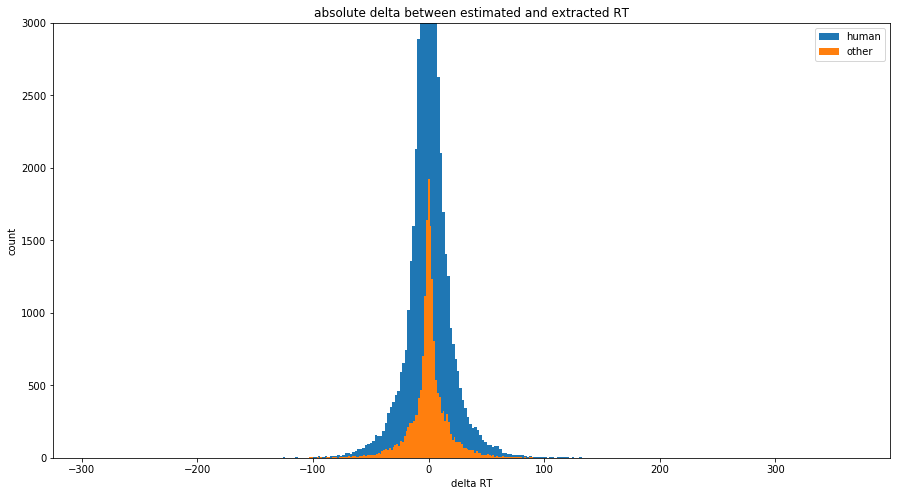

In [101]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
rt_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].absolute_delta_rt
rt_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].absolute_delta_rt

y, x, _ = ax1.hist(rt_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(rt_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta RT')
plt.ylabel('count')
plt.title('absolute delta between estimated and extracted RT')
plt.legend(loc='best')
# plt.xlim((0,120))
plt.ylim((0,3000))

plt.show()

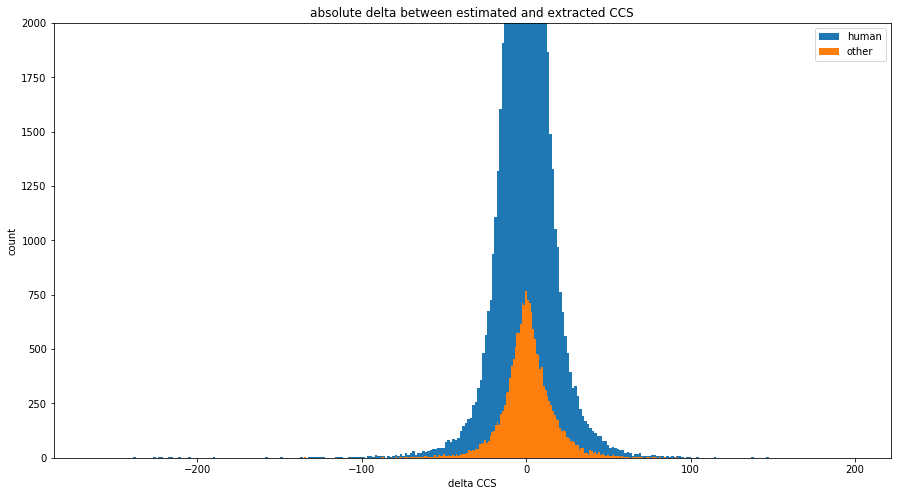

In [102]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
scan_delta_human = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == True)].absolute_delta_scan
scan_delta_other = human_only_df[(human_only_df.classed_as == 'target') & (human_only_df.human == False)].absolute_delta_scan

y, x, _ = ax1.hist(scan_delta_human, bins=bins, label='human')
y, x, _ = ax1.hist(scan_delta_other, bins=bins, label='other')
# mean = np.mean(values)
# ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
# text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
# ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('delta CCS')
plt.ylabel('count')
plt.title('absolute delta between estimated and extracted CCS')
plt.legend(loc='best')
# plt.xlim((0,120))
plt.ylim((0,2000))

plt.show()